In [16]:
import os
from pathlib import Path

import numpy as np
from tqdm.notebook import trange
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from dpipe.io import load, choose_existing
from dpipe.torch import load_model_state

from ttt_lib.q_learning import PolicyPlayer, play_game, train_q_learning, play_duel
from ttt_lib.torch.module.policy_net import PolicyNetworkRandom, PolicyNetworkQ6
from ttt_lib.field import Field
from ttt_lib.utils import choose_model

In [8]:
Q_EXP_PATH = choose_existing(
    Path('/nmnt/x4-hdd/experiments/rl/q_6x6'),
)

os.listdir(Q_EXP_PATH)

['q1_test_upd1', 'q1_test', 'q2_test', 'q2_test_upd1']

# Visualization

In [9]:
exp_path = Q_EXP_PATH / 'q2_test_upd1'

In [10]:
device = 'cpu'
n = 6
kernel_len = 5
cnn_features = (128, 64)

field = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)
model = PolicyNetworkQ6(n=n, structure=cnn_features)
load_model_state(model, exp_path / choose_model(exp_path))

eps = 0
player = PolicyPlayer(model=model, field=field, eps=eps, device=device)
player.eval()

In [11]:
s_history, f_history, a_history, q_history, q_max_history, p_history, value\
    = play_game(player=player, train=False, augm=False)

In [7]:
# code to visualise (s, a) sequence

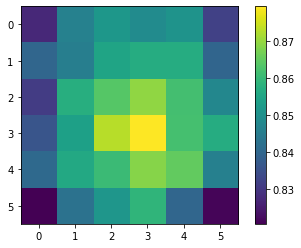

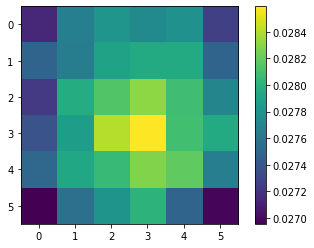

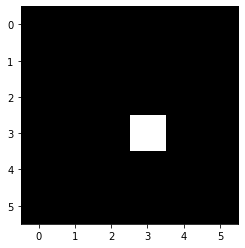

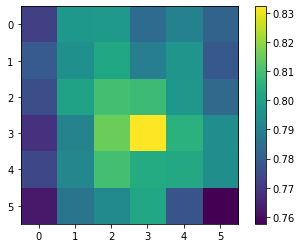

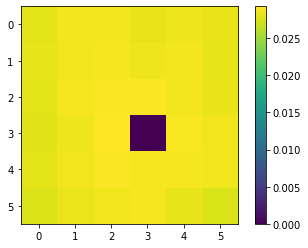

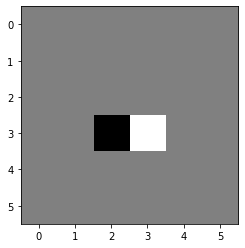

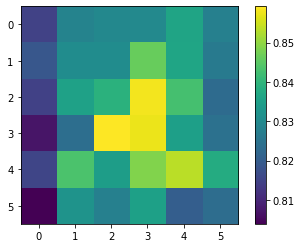

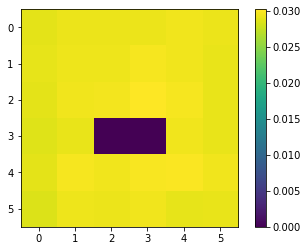

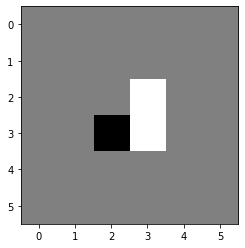

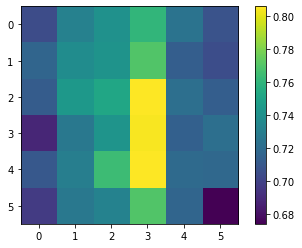

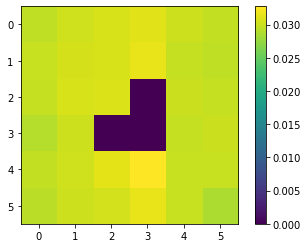

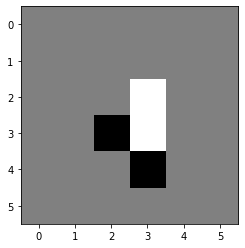

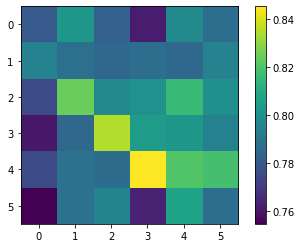

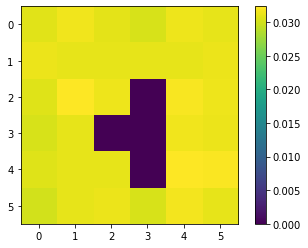

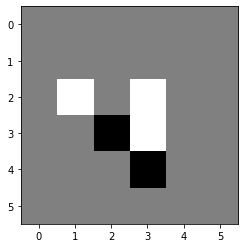

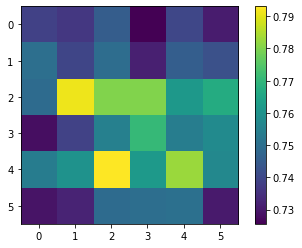

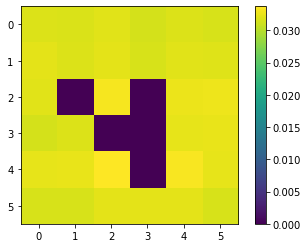

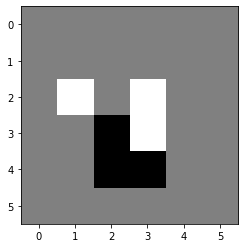

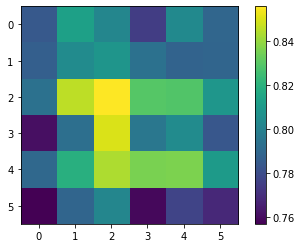

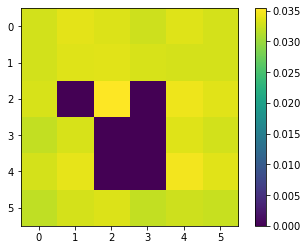

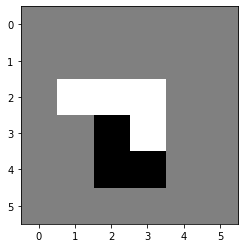

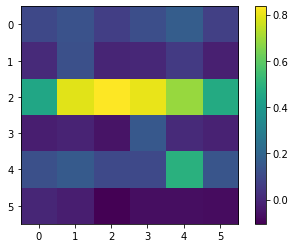

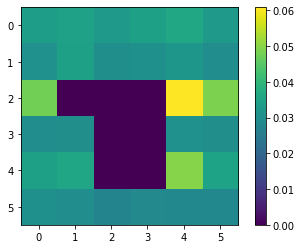

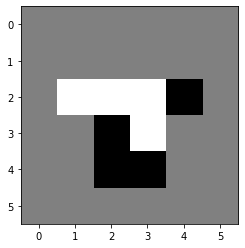

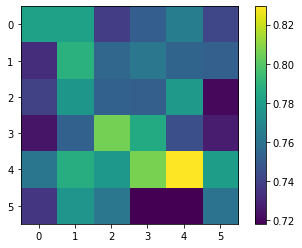

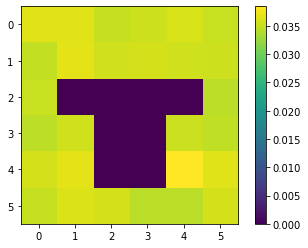

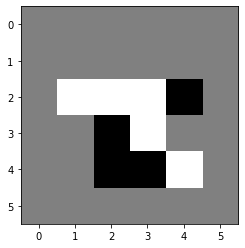

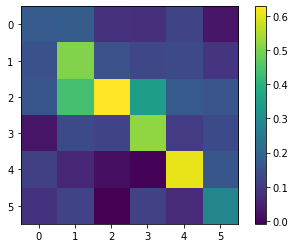

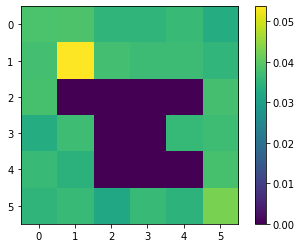

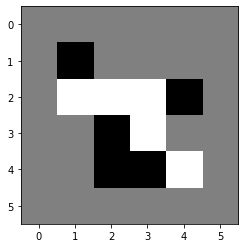

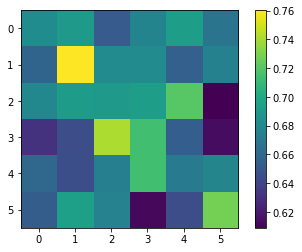

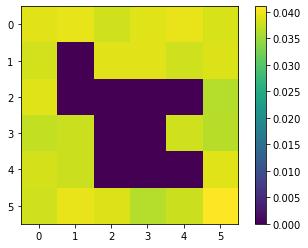

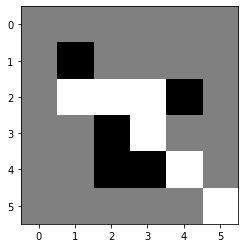

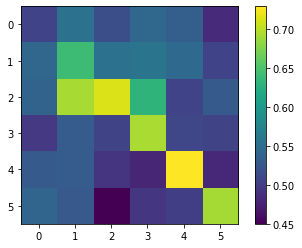

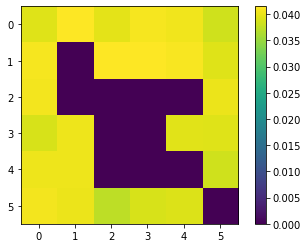

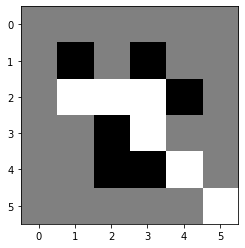

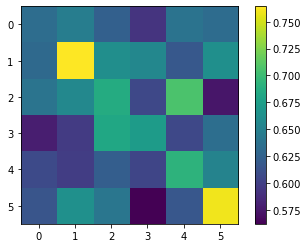

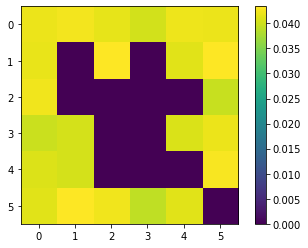

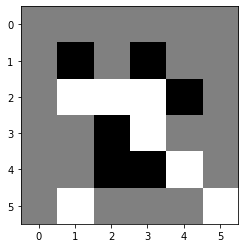

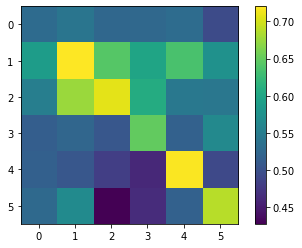

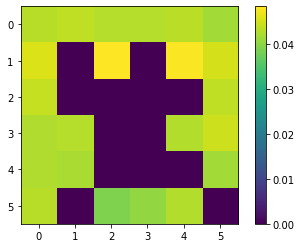

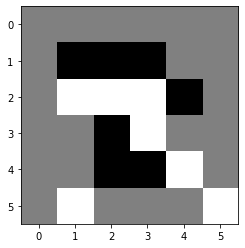

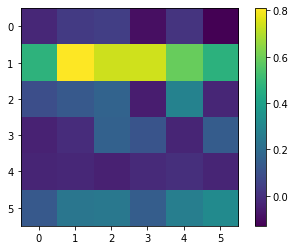

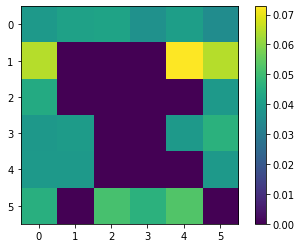

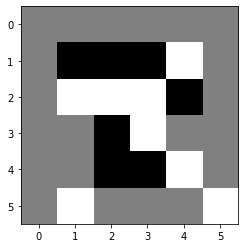

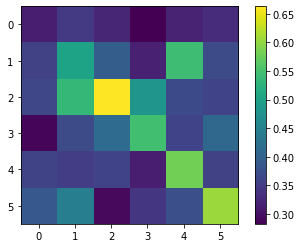

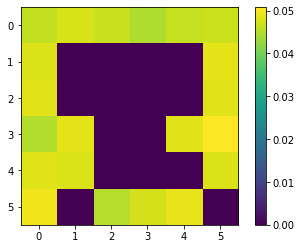

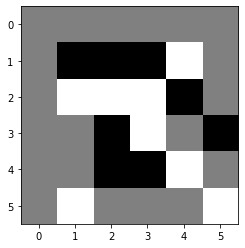

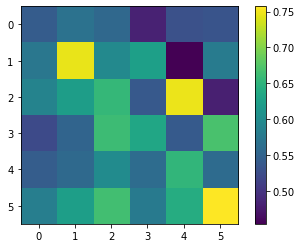

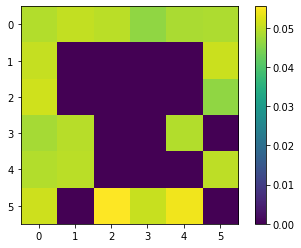

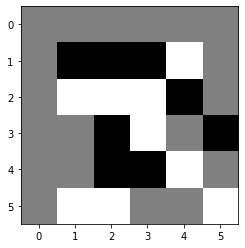

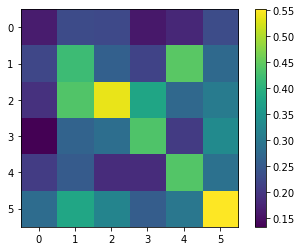

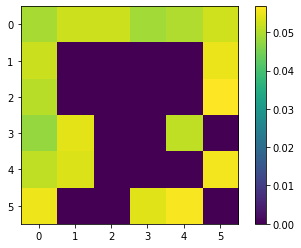

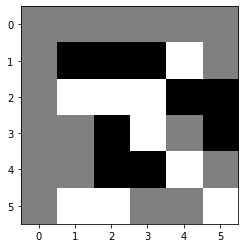

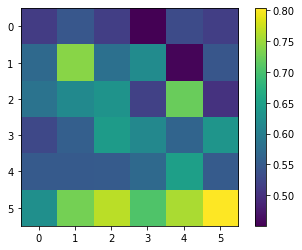

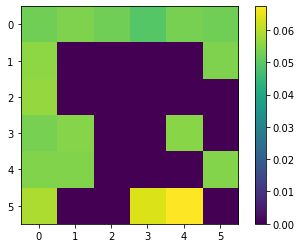

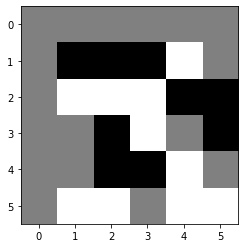

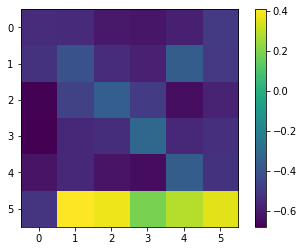

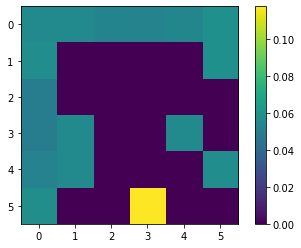

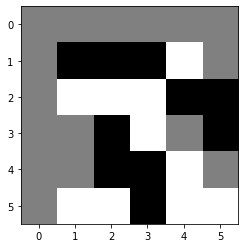

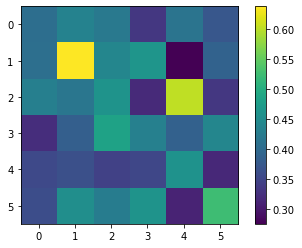

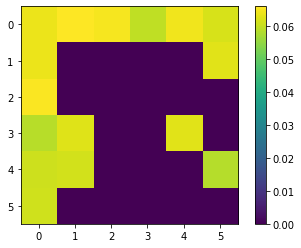

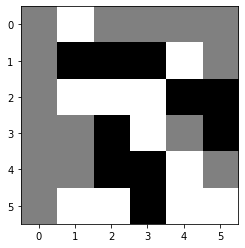

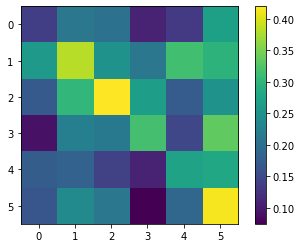

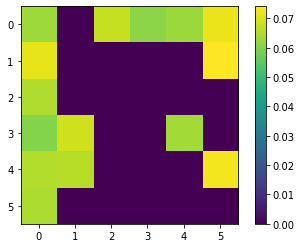

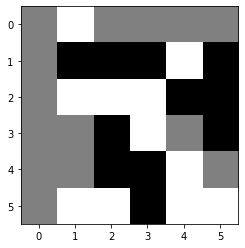

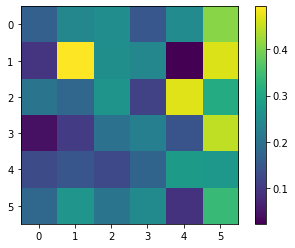

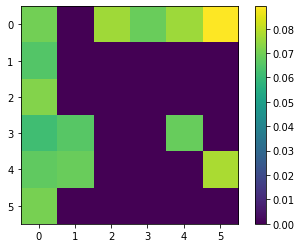

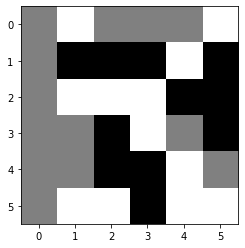

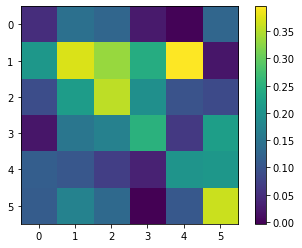

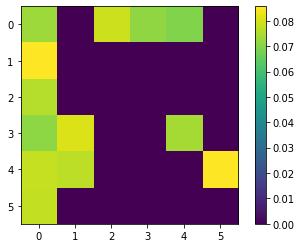

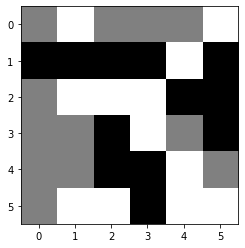

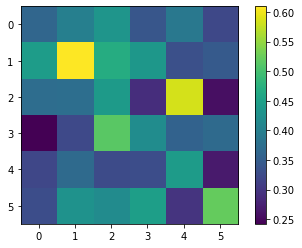

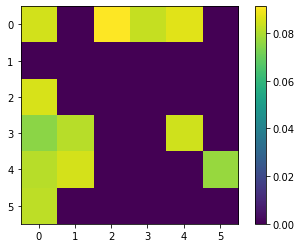

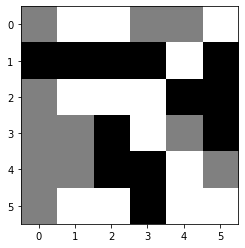

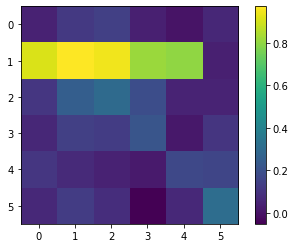

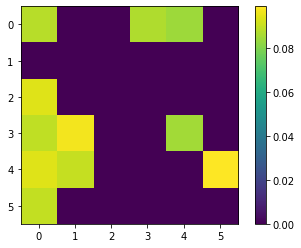

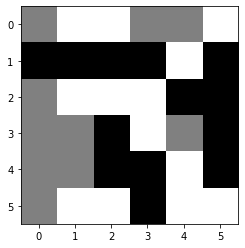

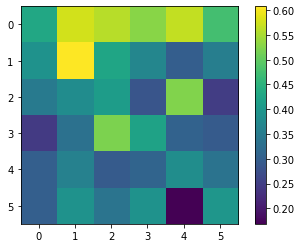

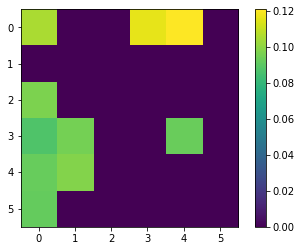

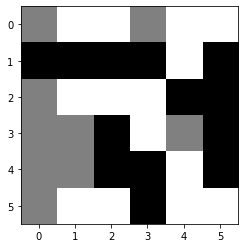

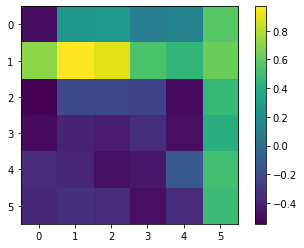

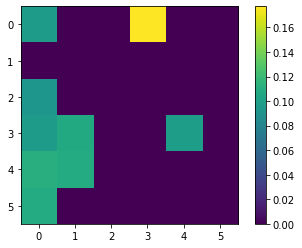

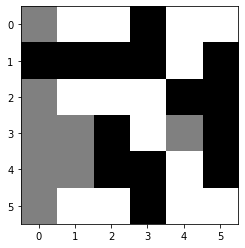

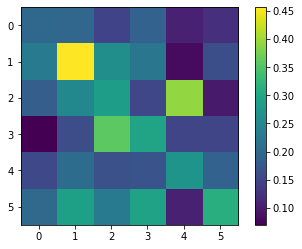

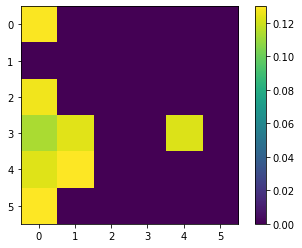

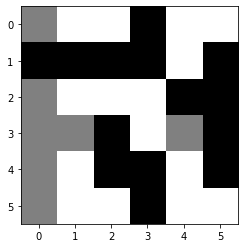

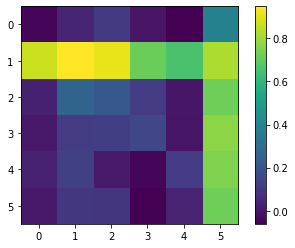

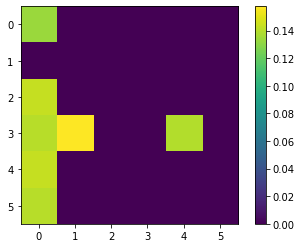

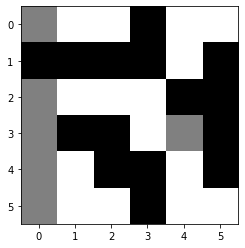

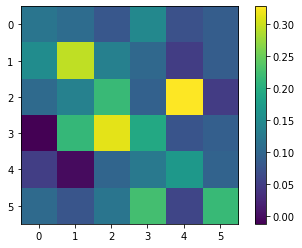

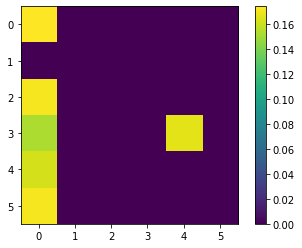

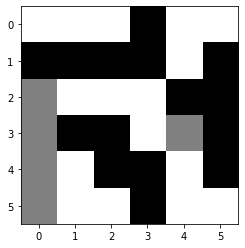

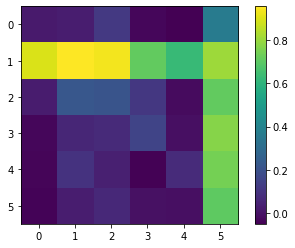

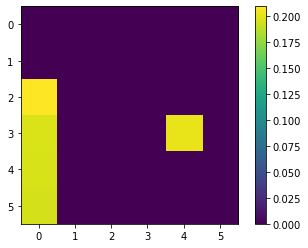

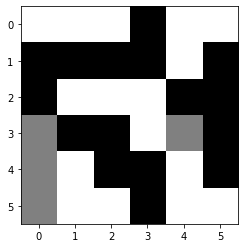

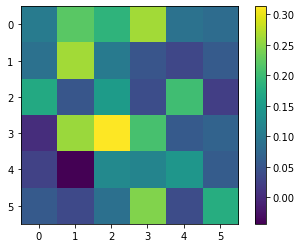

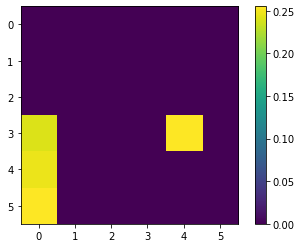

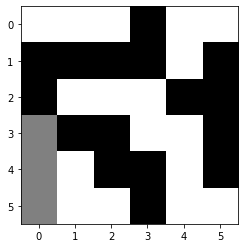

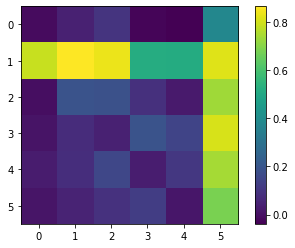

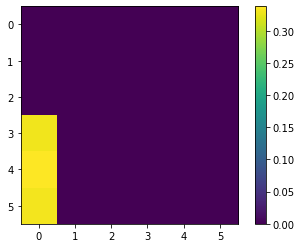

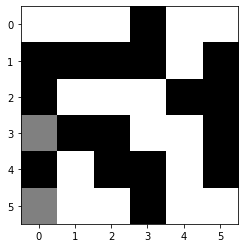

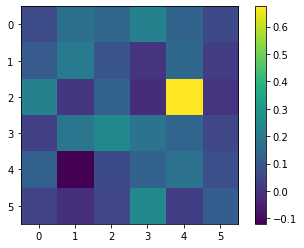

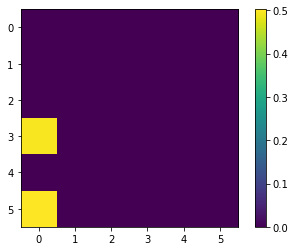

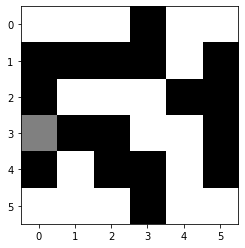

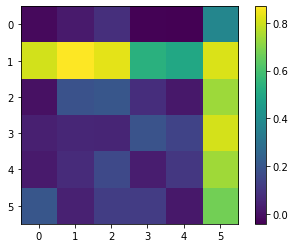

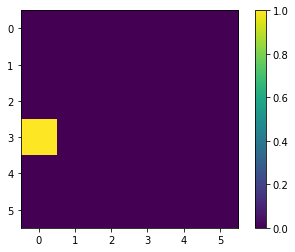

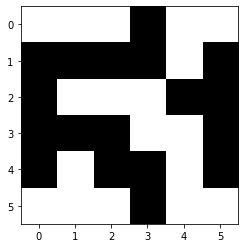

In [12]:
field_v = Field(n, kernel_len)
for s, a, q, p in zip(s_history, a_history, q_history, p_history):
    plt.imshow(q.detach().numpy())
    plt.colorbar()
    plt.show()
    
    plt.imshow(p.detach().numpy())
    plt.colorbar()
    plt.show()

    i, j = a // n, a % n
    field_v.set_state(s)
    field_v.make_move(i, j)
    field_v.show_field()

## Check some manual games

In [14]:
player.update_field(np.zeros((n, n), dtype='float32'))

### Algorithm's policy w/o move

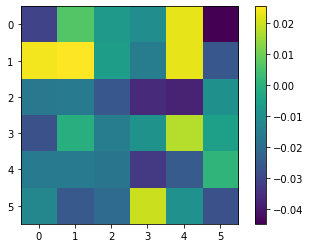

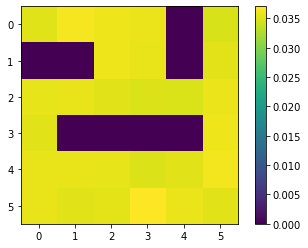

tensor(33)


In [24]:
q, p = player.forward_state()

plt.imshow(q.detach().cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(p.detach().cpu().numpy())
plt.colorbar()
plt.show()

print(p.argmax())

### Algorithm's move

None


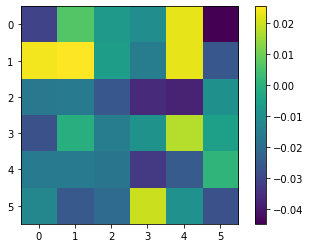

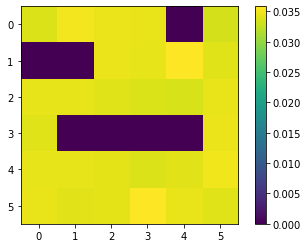

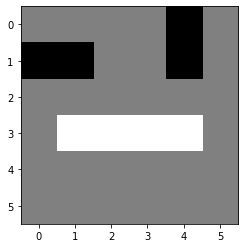

In [23]:
q, p, a, v = player.action(train=False)

print(v)

plt.imshow(q.detach().cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(p.detach().cpu().numpy())
plt.colorbar()
plt.show()

player.field.show_field()

### Manual move

None


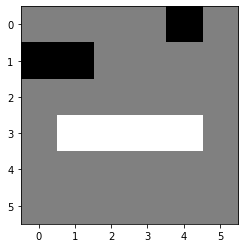

In [22]:
_, _, _, v = player.manual_action(3, 4)

print(v)

player.field.show_field()

## Duel: 1-step vs 2-step Q

In [13]:
exp_path

PosixPath('/nmnt/x4-hdd/experiments/rl/q_6x6/q2_test_upd1')

In [15]:
field_duel = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)

eps = 0.2

player_model_1 = PolicyPlayer(model=PolicyNetworkQ6(n=n, structure=cnn_features),
                              field=field_duel, eps=eps, device=device)
path1 = Path('/nmnt/x4-hdd/experiments/rl/q_6x6/q1_test_upd1')
load_model_state(player_model_1.model, path1 / choose_model(path1))


player_model_2 = PolicyPlayer(model=PolicyNetworkQ6(n=n, structure=cnn_features),
                              field=field_duel, eps=eps, device=device)
path2 = Path('/nmnt/x4-hdd/experiments/rl/q_6x6/q2_test_upd1')
load_model_state(player_model_2.model, path2 / choose_model(path2))

model_random = PolicyNetworkRandom(n=n)
player_random = PolicyPlayer(model=model_random, field=field_duel, eps=1., device=device)

In [17]:
res_1_2, res_2_1 = [], []
for _ in trange(1000):
    sh, fh, ah, qh, ph, w = play_duel(player_model_1, player_model_2, return_result_only=False)
    res_1_2.append(w)
    
    sh, fh, ah, qh, ph, w = play_duel(player_model_2, player_model_1, return_result_only=False)
    res_2_1.append(w)

In [18]:
print(np.mean(np.array(res_1_2) == 1))
print(np.mean(np.array(res_1_2) == 0))
print(np.mean(np.array(res_1_2) == -1))

0.297
0.48
0.223


In [19]:
print(np.mean(np.array(res_2_1) == 1))
print(np.mean(np.array(res_2_1) == 0))
print(np.mean(np.array(res_2_1) == -1))

0.329
0.453
0.218


In [28]:
b = 1

In [29]:
%%timeit
a = (-1) ** 5 * b

33.3 ns ± 0.467 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [30]:
(-1) ** 5 * b

-1

In [31]:
%%timeit
a = (- b) if 5 % 2 == 1 else b

41.8 ns ± 0.214 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
